In [1]:
import pandas as pd
%matplotlib inline
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data_path="./data/"
data=pd.read_csv(data_path+'tesco.csv',index_col='area_id')
data=data.query('month=="yea"')#We consider the data collected over the enitire year
data=data.query('agg_level=="lsoa"')#To be as precise as possible we will study the smallest aggregation level
data=data.drop(columns=['month','agg_level'])
data.head()

,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories
area_id,,,,,,,,
E01000001,8.535149,3.498749,9.213734,5.262429,15.158014,1.622653,163.985327,1.620439
E01000002,8.054729,3.159077,8.337412,5.351774,14.358466,1.692822,157.572172,1.661276
E01000003,8.153757,3.375788,9.414937,5.029519,15.820254,1.522523,163.321285,1.646243
E01000005,8.339058,3.319496,9.603258,5.230254,17.126487,1.612862,169.339310,1.595496
E01000006,9.622101,3.864007,11.355115,5.026295,19.903063,1.640227,190.310015,1.519193


In [3]:
kmean = KMeans(n_clusters=2, random_state=42).fit(data)

In [4]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
    # Get the Silhouette score
    score = silhouette_score(data, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)


sse = []
for k in range(1, 10):
    # Assign the labels to the clusters
    kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
    sse.append({"k": k, "sse": kmeans.inertia_})

sse = pd.DataFrame(sse)

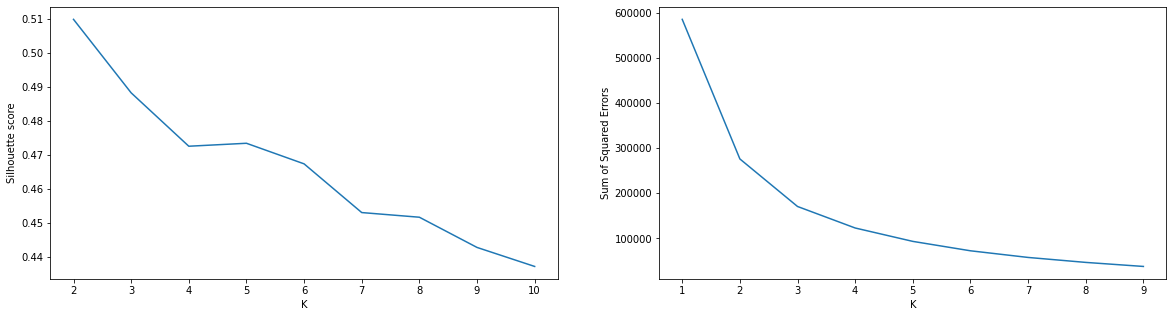

In [5]:
plt.figure(figsize=(20,5))
# Plot the data
plt.subplot(121)
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
# Plot the data
plt.subplot(122)
plt.plot(sse.k, sse.sse)
plt.xlabel("K")
plt.ylabel("Sum of Squared Errors")


plt.show()

In [6]:
k=7

In [7]:
X_reduced_pca = PCA(n_components=2).fit(data).transform(data)
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(data)

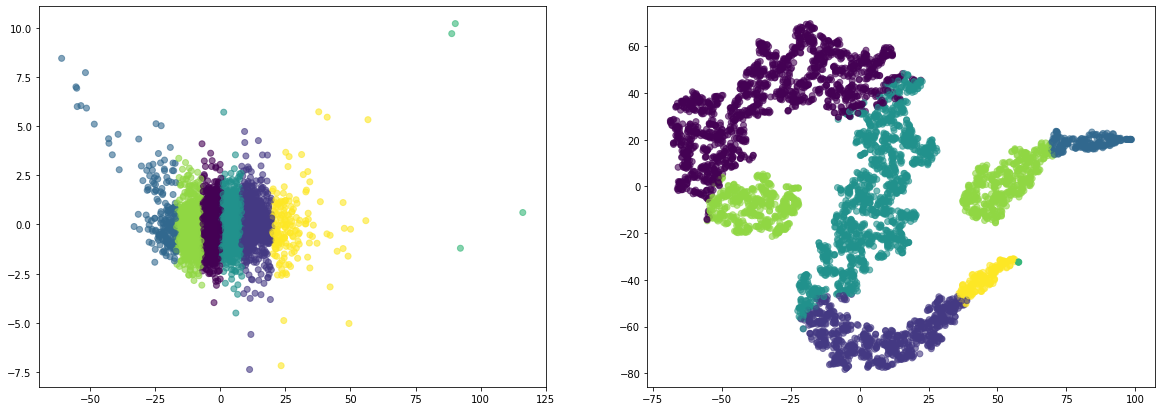

In [8]:
plt.figure(figsize=(20,7))
labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
plt.subplot(121)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
plt.subplot(122)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)

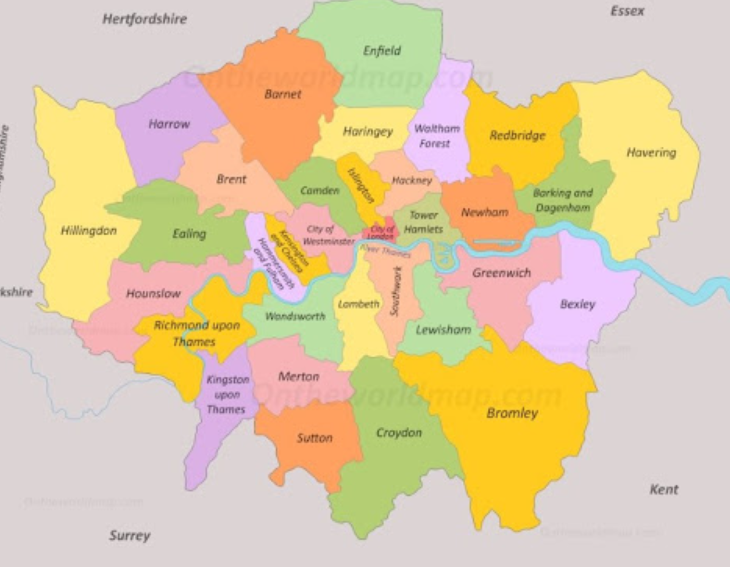

In [9]:
labels

array([2, 2, 2, ..., 3, 3, 0], dtype=int32)

In [65]:
labels = KMeans(n_clusters=4, random_state=42).fit_predict(data)
df = pd.read_csv('data/tesco.csv') 
df['i'] = range(len(df))
start = df[(df.month == 'yea') * (df.agg_level =='lsoa')]['i'].values[0]
df['cluster'] = 'No data'
df['cluster'] = df.apply(lambda r: 'No data' if r.month != 'yea' or r.agg_level!='lsoa' else labels[r.i-start],axis=1)
df = df.drop(columns=['i'])

In [66]:
df.to_csv('data/tesco_cluster.csv',index=False)